In [1]:
# installing keras tuner
!pip install -q keras-tuner

In [2]:
# imports
import numpy as np
np.random.seed(42)
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import RMSprop
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# loading the dataset
df = pd.read_csv('/content/diabetes_dataset.csv')
df.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,0,33.6,0.627,50,1
1,1,85,0,26.6,0.351,31,0
2,8,183,0,23.3,0.672,32,1
3,1,89,94,28.1,0.167,21,0
4,0,137,168,43.1,2.288,33,1


In [4]:
# getting the info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   Insulin                   768 non-null    int64  
 3   BMI                       768 non-null    float64
 4   DiabetesPedigreeFunction  768 non-null    float64
 5   Age                       768 non-null    int64  
 6   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 42.1 KB


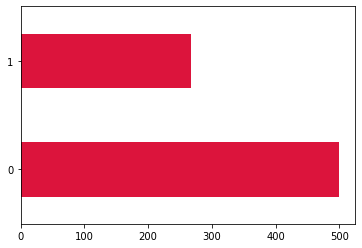

In [5]:
# getting the value count of target; 0 = No, 1 = yes
df['Outcome'].value_counts().plot.barh(color='crimson');

In [6]:
# creating X & y
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

In [7]:
# scaling the X
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# splitting the data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=True, random_state=42)

In [9]:
# defining the search space for hyperparameters

def model_builder(hp):

  model = Sequential()
  
  hp_layer_1 = hp.Int('units_1', min_value=2, max_value=32)
  hp_layer_2 = hp.Int('units_2', min_value=2, max_value=16, step=2)
  hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
  hp_learning_rate = hp.Float('learning_rate', min_value=0.01, max_value=0.05, step=0.01)
  
  model.add(Dense(units=hp_layer_1, activation=hp_activation, input_dim=6))
  model.add(BatchNormalization())
  model.add(Dense(units=hp_layer_2, activation=hp_activation))
  model.add(BatchNormalization())
  model.add(Dense(units=1, activation='sigmoid'))
    
  model.compile(optimizer=RMSprop(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
  return model

In [10]:
# creating a tuner object
tuner = kt.GridSearch(hypermodel=model_builder, objective='val_accuracy', 
                      max_trials=10, directory='mydir', project_name='diabetes', seed=18)

In [11]:
# getting the hps summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 0.05, 'step': 0.01, 'sampling': 'linear'}


In [12]:
# searching for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

In [13]:
# checking the results 
tuner.results_summary(num_trials=1)

Results summary
Results in mydir/diabetes
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
units_1: 2
units_2: 2
activation: tanh
learning_rate: 0.01
Score: 0.7864583134651184


In [14]:
# fetching the best model
model = tuner.get_best_models()[0]

In [15]:
# getting the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 14        
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 batch_normalization_1 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 39
Trainable params: 31
Non-trainable para

In [16]:
# model training with the best hyperparameters
history = model.fit(X_train, y_train, epochs=100, initial_epoch=11, validation_data=(X_test, y_test), verbose=0)

In [17]:
# checking the model performance
_, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
_, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Training: {}, Testing: {}'.format(train_accuracy * 100, test_accuracy * 100))

Training: 79.51388955116272, Testing: 77.08333134651184


In [18]:
# plotting confusion matrix
print(confusion_matrix(
    y_true = y_test,
    y_pred = np.where(model.predict(X_test, verbose=0) > .5, 1, 0)
    ))

[[110  13]
 [ 31  38]]


In [19]:
# plotting classification report
print(classification_report(
    y_true = y_test,
    y_pred = np.where(model.predict(X_test, verbose=0) > .5, 1, 0)
    ))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       123
           1       0.75      0.55      0.63        69

    accuracy                           0.77       192
   macro avg       0.76      0.72      0.73       192
weighted avg       0.77      0.77      0.76       192

